In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, utils

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,precision_score,recall_score,f1_score

from tqdm import tqdm

D:\xz\anaconda\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def load_dataset_as_dataframe(subdir):
    data_dir = os.path.join('dataset', subdir)  # Join 'dataset' and subdir with the correct separator
    filepaths = []
    labels = []

    
    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    classes.sort()  
    print('Classes:', classes)

    
    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        for file in os.listdir(class_dir):
            if file.endswith(('.jpg', '.jpeg', '.png', '.JPG')):
                filepaths.append(os.path.join(class_dir, file))
                labels.append(class_name)

   
    return pd.DataFrame({'Filepath': filepaths, 'Label': labels})


In [3]:
classes = ['Normal', 'Osteoarthritis',]
train_df = load_dataset_as_dataframe('train')
test_df = load_dataset_as_dataframe('test')
val_df = load_dataset_as_dataframe('val')

Classes: ['Normal', 'Osteoarthritis']
Classes: ['Normal', 'Osteoarthritis']
Classes: ['Normal', 'Osteoarthritis']


In [4]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet standards
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

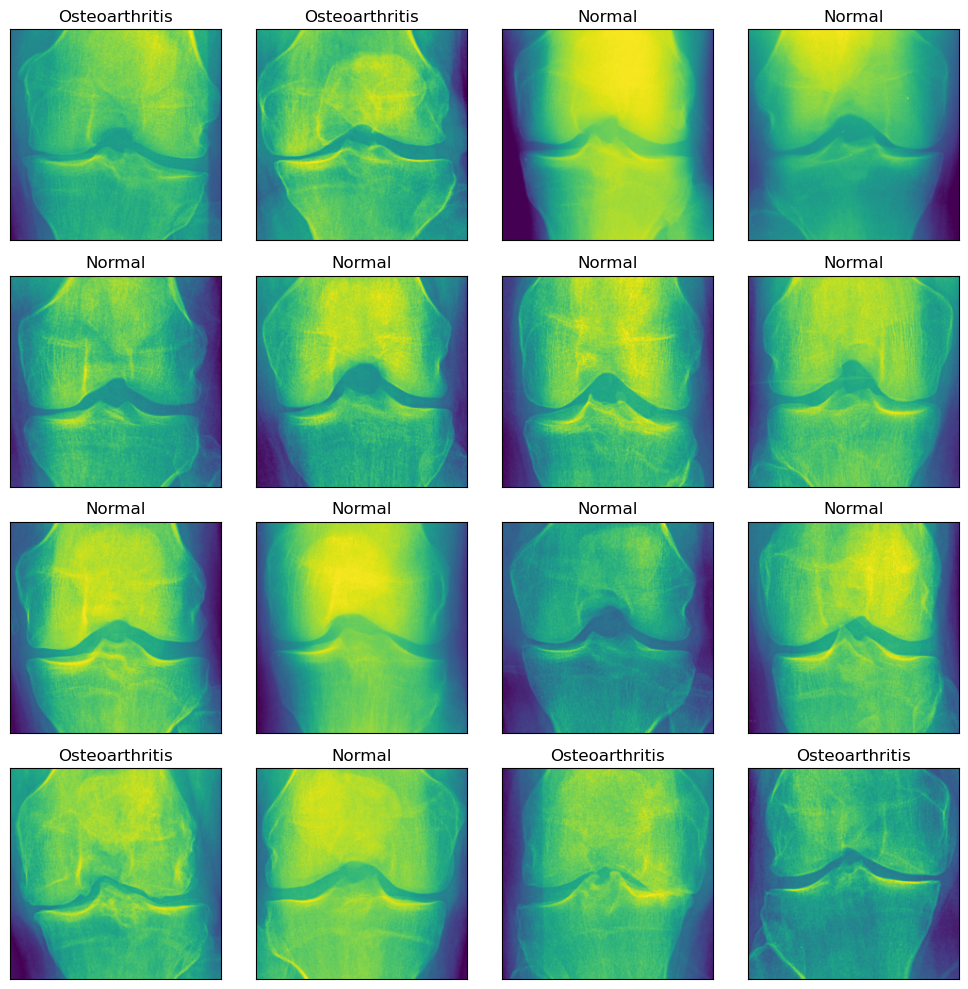

In [5]:
random_index = np.random.randint(0, len(train_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.Filepath[random_index[i]]))
    ax.set_title(train_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [6]:
class KneeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'Filepath']
        label = self.df.loc[idx, 'Label']
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None, None  # Return None to indicate a problematic sample

        if self.transform:
            image = self.transform(image)

        label = classes.index(label)  # Convert label to index
        return image, label


In [7]:
train_dataset = KneeDataset(train_df, transform=train_transform)
test_dataset = KneeDataset(test_df, transform=test_transform)
val_dataset = KneeDataset(val_df, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
def train_and_evaluate(model, optimizer, criterion, num_epochs=5):
    best_val_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_correct = 0
        total_samples = 0
        
        pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            total_correct += torch.sum(preds == labels.data)
            total_samples += labels.size(0)
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{(total_correct/total_samples*100):.2f}%'})

        
        val_accuracy = evaluate_model(model, val_loader, phase='Validation')
        best_val_accuracy = max(best_val_accuracy, val_accuracy)

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = total_correct.double() / len(train_dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    
    return model

In [20]:
def evaluate_model(model, loader, phase='Test'):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"{phase} Metrics: Accuracy={accuracy:.4f}")
    return accuracy, precision, recall, f1

In [10]:
baseline_model = models.resnet18(pretrained=True)
baseline_model.fc = nn.Linear(baseline_model.fc.in_features, len(classes))
baseline_model = baseline_model.to(device)
optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_and_evaluate(baseline_model, optimizer, criterion, num_epochs=10)
print("Training Baseline Model...")

D:\xz\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\xz\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch [1/10]: 100%|██████████| 60/60 [01:43<00:00,  1.73s/it, loss=0.2171, acc=80.90%]


Validation Metrics: Accuracy=0.8958
Epoch 1/10, Loss: 0.4651, Accuracy: 0.8090


Epoch [2/10]: 100%|██████████| 60/60 [01:44<00:00,  1.74s/it, loss=0.4889, acc=92.39%]


Validation Metrics: Accuracy=0.9375
Epoch 2/10, Loss: 0.1940, Accuracy: 0.9239


Epoch [3/10]: 100%|██████████| 60/60 [01:44<00:00,  1.74s/it, loss=0.1377, acc=94.65%]


Validation Metrics: Accuracy=0.8208
Epoch 3/10, Loss: 0.1391, Accuracy: 0.9465


Epoch [4/10]: 100%|██████████| 60/60 [01:43<00:00,  1.73s/it, loss=0.0196, acc=95.12%]


Validation Metrics: Accuracy=0.9333
Epoch 4/10, Loss: 0.1289, Accuracy: 0.9512


Epoch [5/10]: 100%|██████████| 60/60 [01:44<00:00,  1.74s/it, loss=0.1025, acc=96.33%]


Validation Metrics: Accuracy=0.9208
Epoch 5/10, Loss: 0.0874, Accuracy: 0.9633


Epoch [6/10]: 100%|██████████| 60/60 [01:43<00:00,  1.73s/it, loss=0.0437, acc=96.54%]


Validation Metrics: Accuracy=0.9458
Epoch 6/10, Loss: 0.0962, Accuracy: 0.9654


Epoch [7/10]: 100%|██████████| 60/60 [01:44<00:00,  1.74s/it, loss=0.1711, acc=96.33%]


Validation Metrics: Accuracy=0.8917
Epoch 7/10, Loss: 0.1003, Accuracy: 0.9633


Epoch [8/10]: 100%|██████████| 60/60 [01:44<00:00,  1.73s/it, loss=0.0526, acc=96.59%]


Validation Metrics: Accuracy=0.8292
Epoch 8/10, Loss: 0.0923, Accuracy: 0.9659


Epoch [9/10]: 100%|██████████| 60/60 [01:43<00:00,  1.73s/it, loss=0.0289, acc=97.11%]


Validation Metrics: Accuracy=0.9500
Epoch 9/10, Loss: 0.0767, Accuracy: 0.9711


Epoch [10/10]: 100%|██████████| 60/60 [01:43<00:00,  1.73s/it, loss=0.0240, acc=97.32%]


Validation Metrics: Accuracy=0.8708
Epoch 10/10, Loss: 0.0755, Accuracy: 0.9732
Training Baseline Model...


In [11]:
print("\nEvaluating Baseline Model on Test Set...")
evaluate_model(baseline_model, test_loader)


Evaluating Baseline Model on Test Set...
Test Metrics: Accuracy=0.8920


0.8920265780730897

In [12]:
class EnhancedResNet(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedResNet, self).__init__()
        self.model = models.resnet18(pretrained=True)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [13]:
print("\nTraining Enhanced Model...")
enhanced_model = EnhancedResNet(len(classes)).to(device)
optimizer = optim.Adam(enhanced_model.parameters(), lr=0.0005)
train_and_evaluate(enhanced_model, optimizer, criterion, num_epochs=10)

D:\xz\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\xz\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Training Enhanced Model...


Epoch [1/10]: 100%|██████████| 60/60 [01:44<00:00,  1.75s/it, loss=0.1165, acc=84.26%]


Validation Metrics: Accuracy=0.8750
Epoch 1/10, Loss: 0.3692, Accuracy: 0.8426


Epoch [2/10]: 100%|██████████| 60/60 [01:44<00:00,  1.74s/it, loss=0.1732, acc=94.49%]


Validation Metrics: Accuracy=0.7750
Epoch 2/10, Loss: 0.1532, Accuracy: 0.9449


Epoch [3/10]: 100%|██████████| 60/60 [01:46<00:00,  1.78s/it, loss=0.0253, acc=95.96%]


Validation Metrics: Accuracy=0.9458
Epoch 3/10, Loss: 0.1102, Accuracy: 0.9596


Epoch [4/10]: 100%|██████████| 60/60 [01:45<00:00,  1.75s/it, loss=0.0318, acc=96.96%]


Validation Metrics: Accuracy=0.8833
Epoch 4/10, Loss: 0.0837, Accuracy: 0.9696


Epoch [5/10]: 100%|██████████| 60/60 [01:45<00:00,  1.75s/it, loss=0.0736, acc=97.17%]


Validation Metrics: Accuracy=0.9375
Epoch 5/10, Loss: 0.0876, Accuracy: 0.9717


Epoch [6/10]: 100%|██████████| 60/60 [01:45<00:00,  1.75s/it, loss=0.2796, acc=97.90%]


Validation Metrics: Accuracy=0.9542
Epoch 6/10, Loss: 0.0627, Accuracy: 0.9790


Epoch [7/10]: 100%|██████████| 60/60 [01:45<00:00,  1.75s/it, loss=0.0536, acc=97.06%]


Validation Metrics: Accuracy=0.8292
Epoch 7/10, Loss: 0.0802, Accuracy: 0.9706


Epoch [8/10]: 100%|██████████| 60/60 [01:44<00:00,  1.75s/it, loss=0.1535, acc=97.90%]


Validation Metrics: Accuracy=0.8917
Epoch 8/10, Loss: 0.0520, Accuracy: 0.9790


Epoch [9/10]: 100%|██████████| 60/60 [01:44<00:00,  1.75s/it, loss=0.0541, acc=97.95%]


Validation Metrics: Accuracy=0.9500
Epoch 9/10, Loss: 0.0552, Accuracy: 0.9795


Epoch [10/10]: 100%|██████████| 60/60 [01:44<00:00,  1.75s/it, loss=0.1252, acc=98.43%]


Validation Metrics: Accuracy=0.9083
Epoch 10/10, Loss: 0.0373, Accuracy: 0.9843


EnhancedResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [14]:
print("\nEvaluating Enhanced Model on Test Set...")
evaluate_model(enhanced_model, test_loader)


Evaluating Enhanced Model on Test Set...
Test Metrics: Accuracy=0.9635


0.9634551495016611

In [21]:
baseline_accuracy, baseline_precision, baseline_recall, baseline_f1 = evaluate_model(
    baseline_model, test_loader, phase="Baseline Test",
)

print("\nBaseline Model Scores:")
print("Accuracy:", baseline_accuracy)
print("Precision:", baseline_precision)
print("Recall:", baseline_recall)
print("F1-Score:", baseline_f1)

Baseline Test Metrics: Accuracy=0.8920

Baseline Model Scores:
Accuracy: 0.8920265780730897
Precision: 0.898133851707859
Recall: 0.8988116432259212
F1-Score: 0.8920238965769396


In [23]:
enhanced_accuracy, enhanced_precision, enhanced_recall, enhanced_f1 = evaluate_model(
    enhanced_model, test_loader, phase="Enhanced Test",
)


print("\nEnhanced Model Scores:")
print(f"Accuracy: {enhanced_accuracy:.4f}")
print(f"Precision: {enhanced_precision:.4f}")
print(f"Recall: {enhanced_recall:.4f}")
print(f"F1-Score: {enhanced_f1:.4f}")

Enhanced Test Metrics: Accuracy=0.9635

Enhanced Model Scores:
Accuracy: 0.9635
Precision: 0.9627
Recall: 0.9638
F1-Score: 0.9632


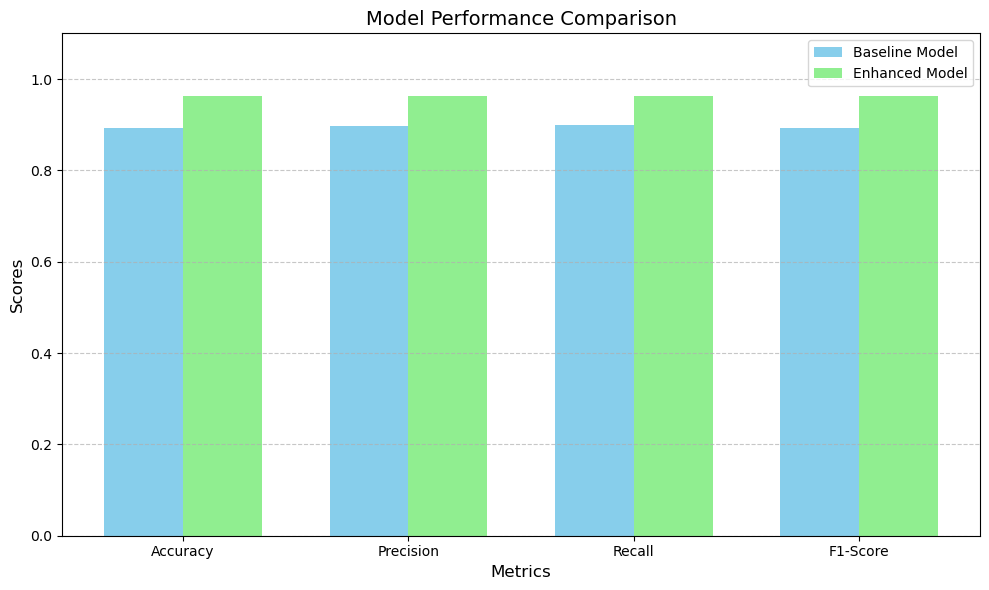

In [34]:
import matplotlib.pyplot as plt
import numpy as np


baseline_scores = [0.8920, 0.8981, 0.8988, 0.8920]  # [Accuracy, Precision, Recall, F1-Score]
enhanced_scores = [0.9635, 0.9627, 0.9638, 0.9632]  # [Accuracy, Precision, Recall, F1-Score]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']


x = np.arange(len(metrics)) 
width = 0.35  


plt.figure(figsize=(10, 6))
plt.bar(x - width/2, baseline_scores, width, label='Baseline Model', color='skyblue')
plt.bar(x + width/2, enhanced_scores, width, label='Enhanced Model', color='lightgreen')


plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.title('Model Performance Comparison', fontsize=14)
plt.xticks(x, metrics, fontsize=10)
plt.ylim(0, 1.1)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


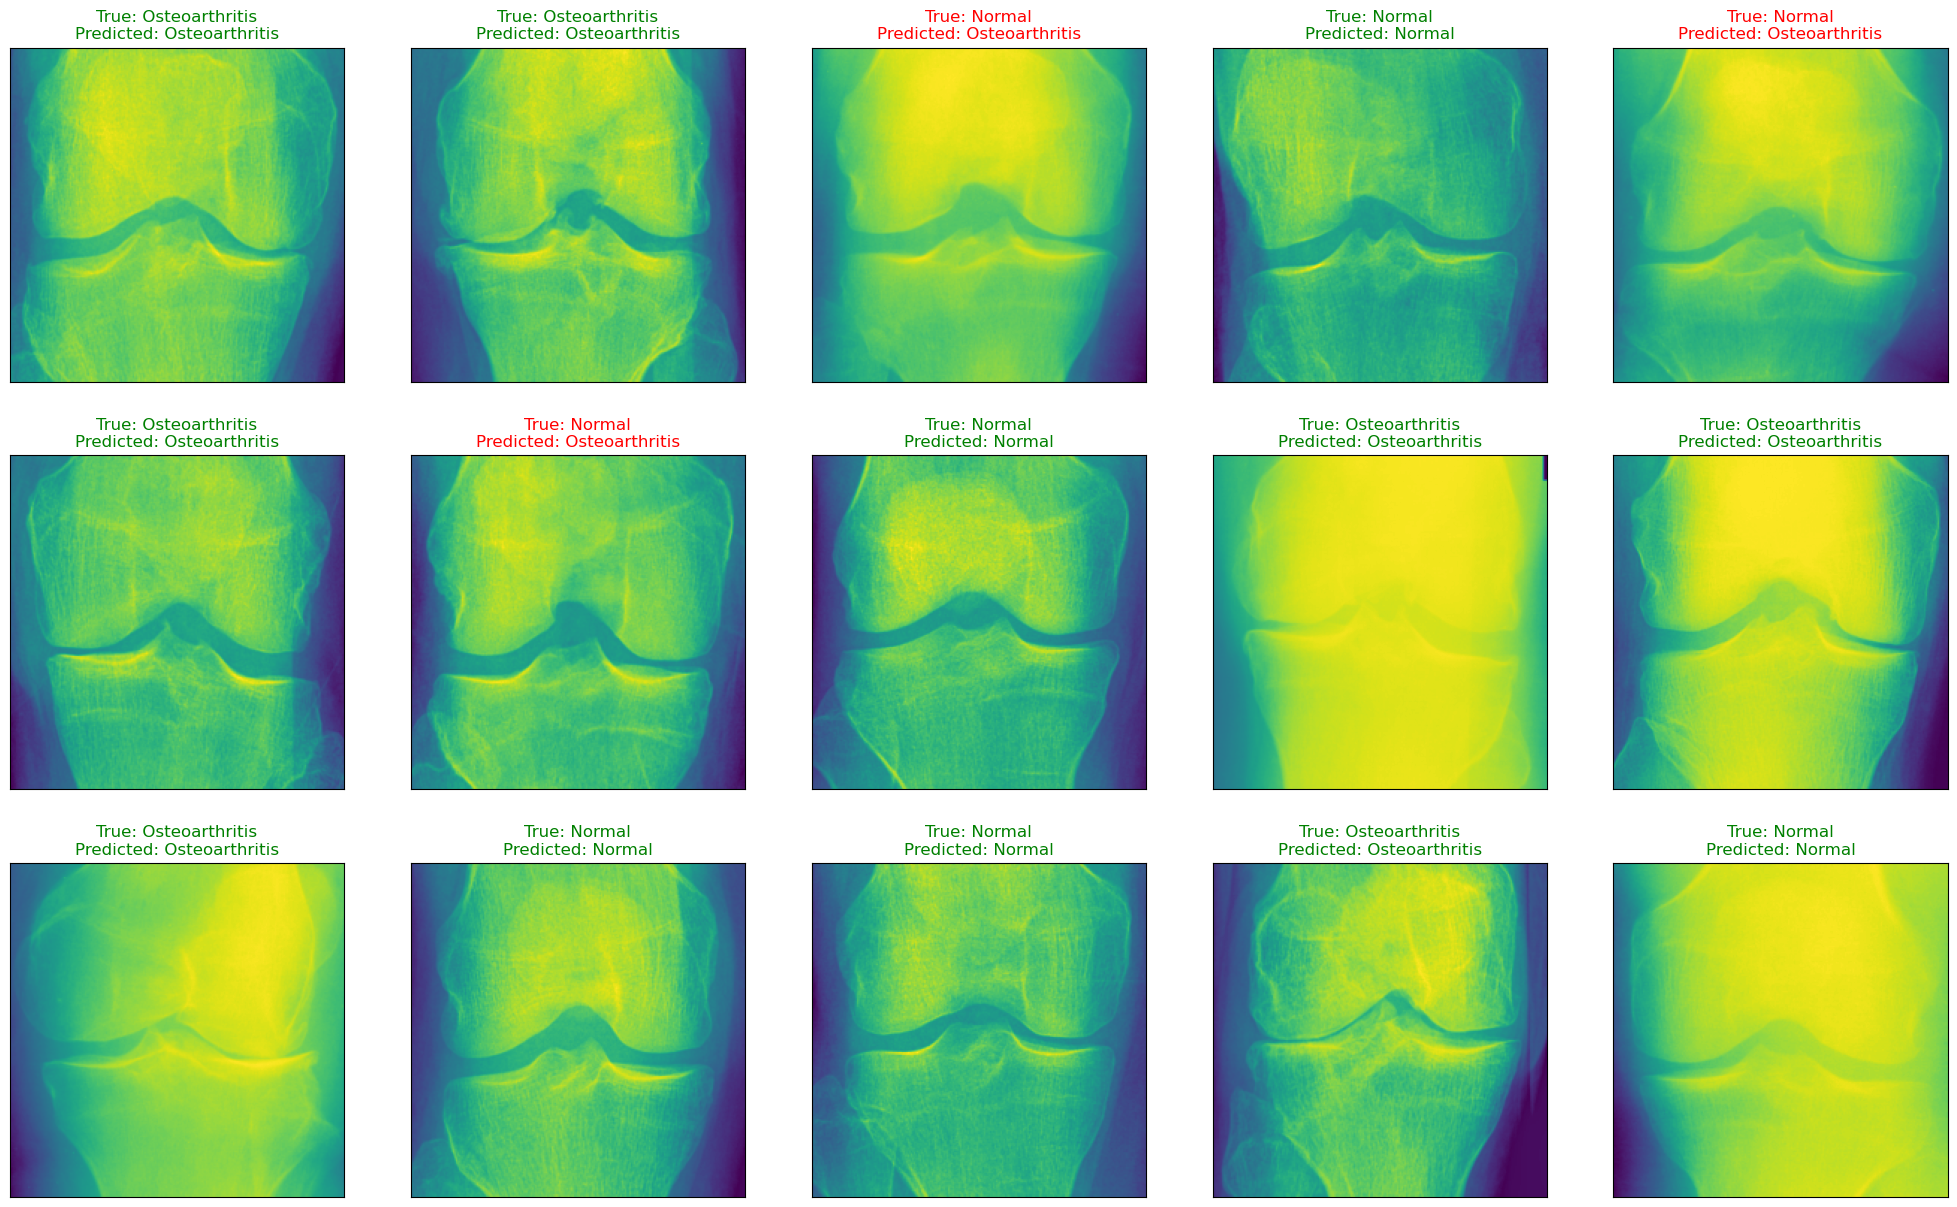

<Figure size 640x480 with 0 Axes>

In [36]:
baseline_model.eval()  


pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = baseline_model(images)  
        _, preds = torch.max(outputs, 1)
        pred.extend(preds.cpu().numpy())


random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == classes[pred[random_index[i]]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {classes[pred[random_index[i]]]}",
                 color=color)

plt.show()
plt.tight_layout()